In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_3Dprint_gpquery import Models, Plotting, PoolObjectives
from joblib import Parallel, delayed

dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Cross-barrel 3D printing parameters and thier mechanical properties
columns = ['n',	'theta','r','t','toughness']
all_data = pd.read_csv('parameterspace.csv')[columns]

# Cross-barrel 3D printing parameters and thier mechanical properties
columns = ['n',	'theta','r','t','toughness']
all_data = pd.read_csv('parameterspace.csv')[columns]

# Sort df by the same columns used in the mask: 'n', 'theta', 'r', 't'
df_sorted = all_data.sort_values(by=['n', 'theta', 'r', 't'])[['n','theta','r',	't',	'toughness']]
train_data = df_sorted.copy()[::3]
train_data['toughness_mean'] = df_sorted['toughness'].groupby(np.arange(len(df_sorted)) // 3).mean(numeric_only=True)
train_data['toughness_variance'] = df_sorted['toughness'].groupby(np.arange(len(df_sorted)) // 3).std(numeric_only=True)

train_data = train_data.reset_index(drop=True)

# print(train_data.head())

x_inputs = train_data[["n", "theta", "r", "t"]]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]
# Set the device and dtype
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=dtype)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=dtype)

# Show top 10 highest toughness values and their corresponding inputs
topk = 10
topk_indices = y_all.flatten().argsort(descending=True)[:topk]
for idx in topk_indices:
    print(f"Toughness: {y_all[idx].item():.4f}, Inputs: {x_all[idx].tolist()}")


Toughness: 46.7114, Inputs: [12.0, 150.0, 1.9, 1.4]
Toughness: 44.9449, Inputs: [12.0, 75.0, 2.4, 1.05]
Toughness: 44.4266, Inputs: [12.0, 25.0, 2.4, 0.7]
Toughness: 43.3273, Inputs: [12.0, 75.0, 2.4, 0.7]
Toughness: 41.5731, Inputs: [12.0, 200.0, 1.5, 1.4]
Toughness: 41.1616, Inputs: [12.0, 125.0, 2.0, 1.4]
Toughness: 40.0132, Inputs: [12.0, 175.0, 1.6, 1.4]
Toughness: 39.7673, Inputs: [10.0, 200.0, 1.7, 1.4]
Toughness: 39.2423, Inputs: [12.0, 100.0, 2.5, 0.7]
Toughness: 39.0914, Inputs: [12.0, 25.0, 2.2, 0.7]


In [3]:
random_seed = 5
iterations = 3

batch_size = 15
# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[x_all[:, 0].min(), x_all[:, 0].max()],
                      [x_all[:, 1].min(), x_all[:, 1].max()],
                      [x_all[:, 2].min(), x_all[:, 2].max()],
                      [x_all[:, 3].min(), x_all[:, 3].max()]], dtype=dtype).T


x_inputs = train_data[['n','theta','r','t'] ]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]
# Set the device and dtype
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=dtype)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=dtype)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=dtype)

query = PoolObjectives(x_inputs, y_outputs ,yvar_outputs, columns=['n', 'theta', 'r', 't'], bounds=original_bounds) 

random.seed(0)
random_indices = random.sample(range(x_all.shape[0]), batch_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train, y_train_var  = query.query_gp(nx_train)

# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)

# plot of ground truth
variable_combinations = [('n', 'r', 't')]
plotting = Plotting(query.ground_truth, variable_combinations=variable_combinations)
combination = variable_combinations[0]
minmax = [y_all.min(), y_all.max()]
plotting.sliced_plotting('ModelA',combination, minmax, colormap='thermal')

#Step 2: Initialize Plotting class
variable_combinations = [('n', 'r', 't')]
plotting = Plotting(gp_model.model, variable_combinations=variable_combinations)
combination = variable_combinations[0]
minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting('ModelA',combination, minmax)




In [4]:
def BO_loop_ModelA(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelA_candidates(feature='theta').drop(columns=['cluster'])
        x_new = torch.tensor(new_candidates[['n', 'theta', 'r', 't']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


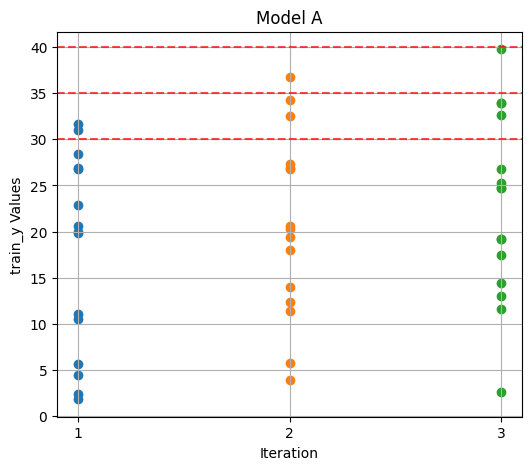

Iteration 1: tensor([ 10.0000, 150.0000,   2.5000,   0.7000], dtype=torch.float64)
Iteration 2: tensor([ 12.0000, 132.0600,   1.9500,   1.0400], dtype=torch.float64)
Iteration 3: tensor([ 12.0000, 135.6400,   1.9800,   1.2900], dtype=torch.float64)


In [5]:
thresholds = [30, 35, 40]

gp_modelA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, query, iterations = iterations)

train_xA = unnormalize(train_nA, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('n', 'r', 't')]
plotting = Plotting(gp_modelA, variable_combinations=variable_combinations)

combination = variable_combinations[1]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)

# Split train_y intoA iterations, each containingA points

points_per_iteration = batch_size
split_data = [train_yA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model A')
plt.xticks(range(1, iterations + 1))

for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



In [6]:
def BO_loop_ModelB(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelB_candidates(feature='theta')#.drop(columns=['cluster'])
        x_new = torch.tensor(new_candidates[['n', 'theta', 'r', 't']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar

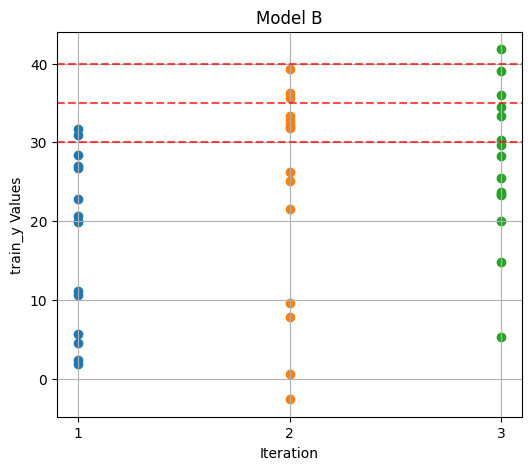

Iteration 1: tensor([ 10.0000, 150.0000,   2.5000,   0.7000], dtype=torch.float64)
Iteration 2: tensor([ 12.0000, 132.0600,   1.8800,   1.4000], dtype=torch.float64)
Iteration 3: tensor([12.0000, 30.7500,  2.4000,  0.7000], dtype=torch.float64)


In [7]:
# Reset Pool
x_inputs = train_data[['n', 'theta', 'r', 't']]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]

gp_modelB, train_nxB, train_yB, train_yvarB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, query, iterations = iterations)

train_xB = unnormalize(train_nxB, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('n', 't', 'r'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelB, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelB',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model B')
plt.xticks(range(1, iterations + 1))
for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [8]:
def BO_loop_ModelC(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelC_candidates(feature='theta')#.drop(columns=['cluster'])
        x_new = torch.tensor(new_candidates[['n', 'theta', 'r', 't']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar

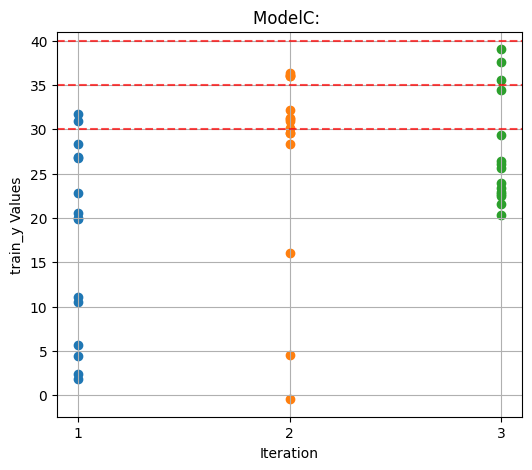

Iteration 1: tensor([ 10.0000, 150.0000,   2.5000,   0.7000], dtype=torch.float64)
Iteration 2: tensor([ 12.0000, 115.5800,   2.4400,   0.7000], dtype=torch.float64)
Iteration 3: tensor([12.0000, 22.0100,  2.3000,  0.7000], dtype=torch.float64)


In [9]:
# Reset 
x_inputs = train_data[['n', 'theta', 'r', 't']]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]

gp_modelC, train_nxC, train_yC, train_yvarC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, query, iterations = iterations)

train_xC = unnormalize(train_nxC, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelC, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('ModelC: ')
plt.xticks(range(1, iterations + 1))
for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



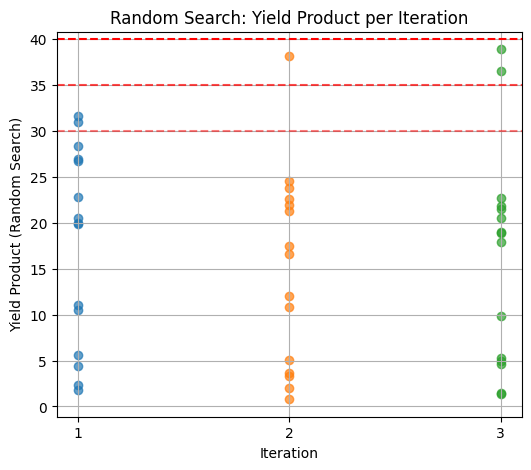

In [10]:
# Perform a random search on set_dataA for 5 random samples

iteration = np.arange(1, iterations+1)

num_samples = batch_size * (iterations-1)
random_samples = train_data.sample(n=num_samples, random_state=random_seed)
# Combine y_train (tensor) and the remaining random samples (list of Series)
y_train_df = pd.DataFrame(y_train.numpy(), columns=['toughness_mean'])
random_sampling = [y_train_df] + [random_samples.iloc[i*batch_size:(i+1)*batch_size]['toughness_mean'] for i in range(iterations-1)]


plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples.values, alpha=0.7)
plt.xlabel('Iteration')
plt.axhline(y=thresholds[2], color='red', linestyle='--', label='y=40')
plt.axhline(y=thresholds[1], color='red', linestyle='--', label='y=40', alpha=0.7)
plt.axhline(y=thresholds[0], color='red', linestyle='--', label='y=40', alpha=0.5)
plt.ylabel('Yield Product (Random Search)')
plt.title('Random Search: Yield Product per Iteration')
plt.grid(True)
plt.xticks(range(1, iterations + 1))
plt.show()


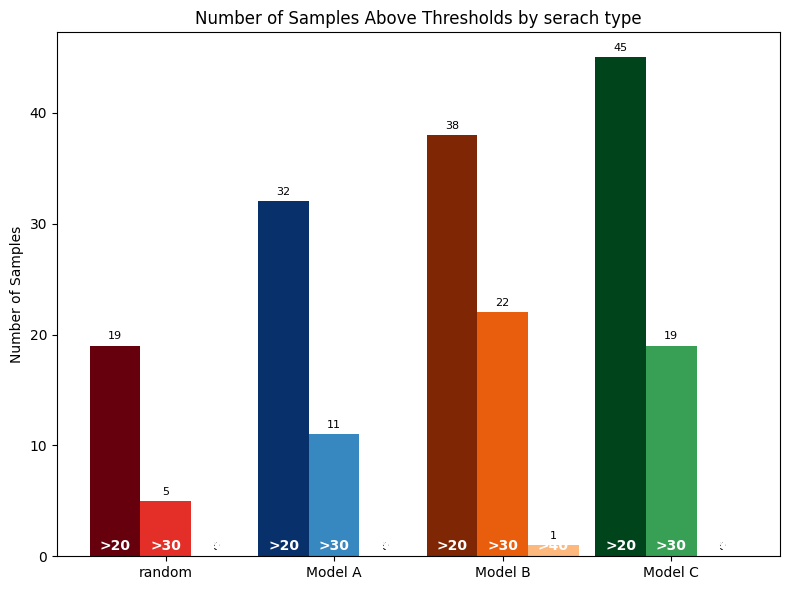

In [11]:
# Check Data
thresholds = [20, 30, 40]

flattened_random_sampling = pd.concat(random_sampling).values.flatten().reshape(-1, 1)

idsA = [(train_yA > thresh).sum().item() for thresh in thresholds]
idsB = [(train_yB > thresh).sum().item() for thresh in thresholds]
idsC = [(train_yC > thresh).sum().item() for thresh in thresholds]
ids_random = [(flattened_random_sampling > thresh).sum().item() for thresh in thresholds]


model_counts =[ids_random,idsA,idsB,idsC] 
model_names = ['random','ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'random':cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['random','Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples Above Thresholds by serach type')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'>{thresholds[j]:.0f}', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()



In [12]:
plotting = Plotting(gp_modelA.model, variable_combinations=('n', 'r', 't'))
plotting.sliced_plotting('ModelA',('n', 'r', 't'), minmax)

plotting = Plotting(gp_modelB.model, variable_combinations=variable_combinations)
plotting.sliced_plotting('ModelB',('n', 'r', 't'), minmax, colormap= 'plasma')

plotting = Plotting(gp_modelC.model, variable_combinations=variable_combinations)
plotting.sliced_plotting('ModelC',('n', 'r', 't'), minmax, colormap = 'cividis')

In [13]:
# Run random sampling 20 times with different seeds and store threshold counts
# Q: run the random sampling 20 times with a differnt seed and store the threshold counts
num_runs = 20
random_threshold_counts = []

for seed in range(num_runs):
    random_samples = train_data.sample(n=num_samples, random_state=seed)
    y_train_df = pd.DataFrame(y_train.numpy(), columns=['toughness_mean'])
    random_sampling = [y_train_df] + [random_samples.iloc[i*batch_size:(i+1)*batch_size]['toughness_mean'] for i in range(iterations-1)]
    flattened = pd.concat(random_sampling).values.flatten().reshape(-1, 1)
    counts = [(flattened > thresh).sum() for thresh in thresholds]
    random_threshold_counts.append(counts)



In [14]:
def run_single_seed(seed, select):
    random.seed(seed)
    torch.manual_seed(seed)

    # Sample a new initial batch for each run
    random_indices = random.sample(range(x_all.shape[0]), batch_size)
    x_train = x_all[random_indices]
    nx_train = normalize(x_train, bounds=original_bounds)
    y_train = query.query_gp(nx_train)[0]  # Get y values for the initial batch
    y_train_var = query.query_gp(nx_train)[1]  # Get y variance for the initial batch

    # Initialize model
    gp_model = Models(
        x_train=nx_train, y_train=y_train, y_train_var=y_train_var,
        bounds=original_bounds, batch_size=batch_size,
        objective=query, random_id=seed
    )
    # Run BO loop
    if select == 'ModelA':
        # Run BO loop
        model, train_n, train_y, train_yva = BO_loop_ModelA(
            gp_model, nx_train, y_train, y_train_var,
            query, iterations=iterations
        )
        # Run BO loop
    elif select == 'ModelB':
        # Run BO loop
        model, train_n, train_y, train_yva = BO_loop_ModelB(
            gp_model, nx_train, y_train, y_train_var,
            query, iterations=iterations
        )
    elif select == 'ModelC':
        # Run BO loop
        model, train_n, train_y, train_yva = BO_loop_ModelC(
            gp_model, nx_train, y_train, y_train_var,
            query, iterations=iterations
        )
    else:
        raise ValueError("Invalid model selection. Choose 'ModelA', 'ModelB', or 'ModelC'.")

    # Count above thresholds
    counts = [(train_y > thresh).sum().item() for thresh in thresholds]
    return counts





In [15]:
num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed, 'ModelA') for seed in range(num_runs))
# Combine into final array/list
modelA_threshold_counts = results

In [ ]:
num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed, 'ModelB') for seed in range(num_runs))
# Combine into final array/list
modelB_threshold_counts = results

In [ ]:
num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed, 'ModelC') for seed in range(num_runs))
# Combine into final array/list
modelC_threshold_counts = results

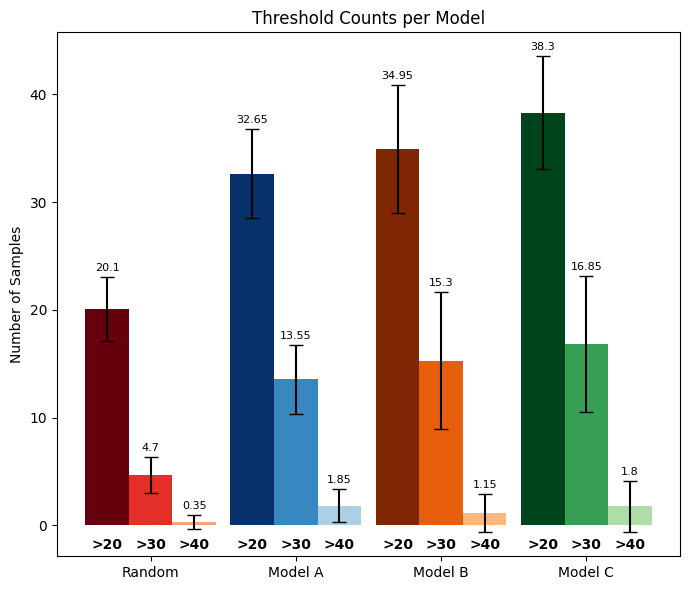

In [ ]:
# Assuming thresholds is defined somewhere, e.g.:
# thresholds = [0.5, 0.7, 0.9]

# Convert results to numpy arrays if not already
modelA_threshold_counts = np.array(modelA_threshold_counts)
modelB_threshold_counts = np.array(modelB_threshold_counts)
modelC_threshold_counts = np.array(modelC_threshold_counts)
random_threshold_counts = np.array(random_threshold_counts)

# Compute mean and std for each threshold
mean_counts = [
    random_threshold_counts.mean(axis=0),
    modelA_threshold_counts.mean(axis=0),
    modelB_threshold_counts.mean(axis=0),
    modelC_threshold_counts.mean(axis=0),
]
std_counts = [
    random_threshold_counts.std(axis=0),
    modelA_threshold_counts.std(axis=0),
    modelB_threshold_counts.std(axis=0),
    modelC_threshold_counts.std(axis=0),
]

model_names = ['random', 'ModelA', 'ModelB', 'ModelC']
num_models = len(model_names)
num_thresholds = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(num_models)

# Colormap mapping
cmap_dict = {'random': cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot each threshold group across all models
for j, threshold in enumerate(thresholds):
    # For each threshold, collect the counts and stds from all models
    counts = [mean_counts[i][j] for i in range(num_models)]
    stds = [std_counts[i][j] for i in range(num_models)]
    cmap_colors = [cmap_dict[model_names[i]](1 - j / num_thresholds) for i in range(num_models)]
    xpos = x + (j - 1) * bar_width  # Shift bars left/right around center

    rects = ax.bar(xpos, counts, width=bar_width, color=cmap_colors, yerr=stds, capsize=5, label=f'Threshold {threshold:.1f}')
    ax.bar_label(rects, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Random', 'Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')
ax.set_title('Threshold Counts per Model')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, -2.5, f'>{thresholds[j]:.0f}', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='k')


plt.tight_layout()
plt.show()

In [ ]:
# num_runs = 20
# modelA_threshold_counts = []
# count = 0
# for seed in range(num_runs):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     # Sample a new initial batch for each run
#     random_indices = random.sample(range(x_all.shape[0]), batch_size)
#     x_train = x_all[random_indices]
#     nx_train = normalize(x_train, bounds=original_bounds)
#     y_train = y_all[random_indices]
#     y_train_var = yvar_all[random_indices]

#     # Prepare pool for querying
#     x_train_np = x_train.cpu().numpy()
#     mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
#     x_input_new = x_inputs[mask]
#     y_output_new = y_outputs[mask]
#     yvar_output_new = yvar_outputs[mask]
#     query = PoolObjectives(x_input_new, y_output_new, yvar_output_new, columns=['n', 'theta', 'r', 't'])

#     # Initialize model
#     gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query, random_id=seed)
#     # Run BO loop
#     gp_modelA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new, yvar_output_new, iterations=iterations)
#     # Count above thresholds
#     counts = [(train_yA > thresh).sum().item() for thresh in thresholds]
#     modelA_threshold_counts.append(counts)
#     count = count + 1
#     print(count)

# num_runs = 20
# modelB_threshold_counts = []
# count = 0
# for seed in range(num_runs):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     # Sample a new initial batch for each run
#     random_indices = random.sample(range(x_all.shape[0]), batch_size)
#     x_train = x_all[random_indices]
#     nx_train = normalize(x_train, bounds=original_bounds)
#     y_train = y_all[random_indices]
#     y_train_var = yvar_all[random_indices]

#     # Prepare pool for querying
#     x_train_np = x_train.cpu().numpy()
#     mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
#     x_input_new = x_inputs[mask]
#     y_output_new = y_outputs[mask]
#     yvar_output_new = yvar_outputs[mask]
#     query = PoolObjectives(x_input_new, y_output_new, yvar_output_new, columns=['n', 'theta', 'r', 't'])

#     # Initialize model
#     gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query, random_id=seed)
#     # Run BO loop
#     gp_modelB, train_nB, train_yB, train_yvaB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new, yvar_output_new, iterations=iterations)
#     # Count above thresholds
#     counts = [(train_yB > thresh).sum().item() for thresh in thresholds]
#     modelB_threshold_counts.append(counts)
#     count = count + 1
#     print(count)

# num_runs = 20
# modelC_threshold_counts = []
# count = 0
# for seed in range(num_runs):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     # Sample a new initial batch for each run
#     random_indices = random.sample(range(x_all.shape[0]), batch_size)
#     x_train = x_all[random_indices]
#     nx_train = normalize(x_train, bounds=original_bounds)
#     y_train = y_all[random_indices]
#     y_train_var = yvar_all[random_indices]

#     # Prepare pool for querying
#     x_train_np = x_train.cpu().numpy()
#     mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
#     x_input_new = x_inputs[mask]
#     y_output_new = y_outputs[mask]
#     yvar_output_new = yvar_outputs[mask]
#     query = PoolObjectives(x_input_new, y_output_new, yvar_output_new, columns=['n', 'theta', 'r', 't'])

#     # Initialize model
#     gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query, random_id=seed)
#     # Run BO loop
#     gp_modelC, train_nC, train_yC, train_yvaC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new, yvar_output_new, iterations=iterations)
#     # Count above thresholds
#     counts = [(train_yC > thresh).sum().item() for thresh in thresholds]
#     modelC_threshold_counts.append(counts)
#     count = count + 1
#     print(count)
